In [1]:
import sys
from os.path import join, exists, abspath
from os import getcwd
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colormaps, cm, colors
import scipy
import h5py
import seaborn as sns

from tqdm import tqdm

In [2]:
import nibabel as nb
from nilearn import plotting
from nipype.interfaces import fsl

In [3]:
dir_current = getcwd().replace('\\','/')

tmp = dir_current.split('/')
idx = [ii for ii, s in enumerate(tmp) if s=='github'][0]

dir_git = '/'.join(tmp[:idx+1])
dir_git

'D:/mobaxterm/sungbeenpark/github'

In [4]:
path_module = abspath(join(dir_git,'nitools'))
if exists(path_module):
    print('added the path, %s'%path_module)
    if path_module not in sys.path:
        sys.path.append(path_module)

import nitools as nt

added the path, D:\mobaxterm\sungbeenpark\github\nitools


In [5]:
path_module = abspath(join(dir_git,'SUITPy'))
if exists(path_module):
    print('added the path, %s'%path_module)
    if path_module not in sys.path:
        sys.path.append(path_module)

import SUITPy as suit

added the path, D:\mobaxterm\sungbeenpark\github\SUITPy


In [6]:
path_module = abspath(dir_git)
if exists(path_module):
    print('added the path, %s'%path_module)
    if path_module not in sys.path:
        sys.path.append(path_module)

import surfAnalysisPy as surf

added the path, D:\mobaxterm\sungbeenpark\github


In [11]:
dir_work = join('F:/SeqSpatialSupp_fMRI')
dir_glm = join(dir_work,'glm_2')

In [12]:
tmp = [1,2,3,5,6,8,9,10,11,12,13,14]
list_nn = ['%02d'%i for i in tmp]
list_nn

['01', '02', '03', '05', '06', '08', '09', '10', '11', '12', '13', '14']

---

## Design Matrix

In [13]:
subj = 'S01'
fname = join(dir_glm,subj,'SPM.mat')
exists(fname)

True

In [14]:
feature = h5py.File(fname)
# feature = scipy.io.loadmat(fname)
print(feature.keys())

data = feature['SPM']
# data.keys()

<KeysViewHDF5 ['#refs#', 'SPM']>


In [15]:
print(data['xX'].keys())
mat_X = data['xX']['X'][:].T
print(mat_X.shape)

## interest
idx_col = np.concatenate(data['xX']['iC'][:]).astype(int) - 1
## non-insterest (baseline)
# idx_col = np.concatenate(data['xX']['iB'][:]).astype(int)

mat_X = mat_X[:,idx_col]
print(mat_X.shape)

<KeysViewHDF5 ['Bcov', 'K', 'V', 'W', 'X', 'erdf', 'iB', 'iC', 'iG', 'iH', 'nKX', 'name', 'pKX', 'trRV', 'trRVRV', 'xKXs']>
(3280, 80)
(3280, 72)


<Axes: >

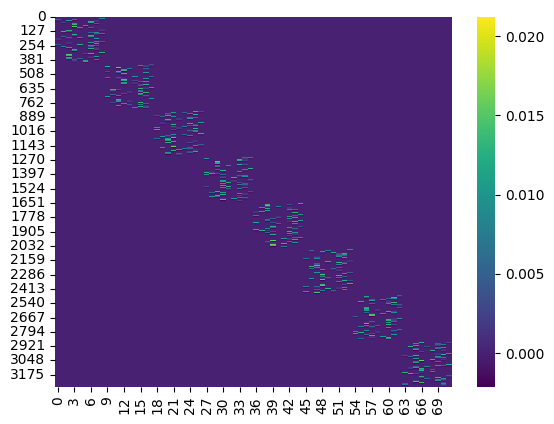

In [16]:
sns.heatmap(mat_X, cmap=cm.viridis)

### Basis function (hrf)

In [39]:
xBF = data['xBF']
for feature in ['T0','T','params','dt','length']:
    val = xBF[feature][:].flatten()
    if feature == 'T0':
        ti = val[0]
    elif feature == 'length':
        tf = val[0]
    elif feature == 'dt':
        dt = val[0]
    print(feature, val)

T0 [1.]
T [16.]
params [ 6. 16.]
dt [0.0625]
length [32.0625]


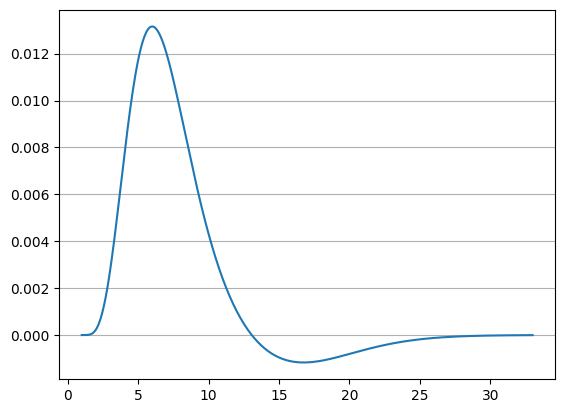

In [41]:
x = np.arange(ti,tf+1,dt)
y = xBF['bf'][:].reshape(-1)

plt.plot(x, y)
plt.grid(axis='y')

- nrows = 410 tr/run * 8 runs = 3280
- ncols = 9 regressors/run * 8 runs + 8 basis = 80 regressors
    - 9 regressors = ['MotorOnly-L', 'MotorOnly-S', 'CueOnly-L', 'CueOnly-S', 'BothRep-L', 'BothRep-S', 'NonRep-L', 'NonRep-S', 'Non-Interest']

In [42]:
list_reg = [
    'MotorOnly-L','MotorOnly-S','CueOnly-L','CueOnly-S','BothRep-L',
    'BothRep-S','NonRep-L','NonRep-S','Non-Interest'
]
list_reg

['MotorOnly-L',
 'MotorOnly-S',
 'CueOnly-L',
 'CueOnly-S',
 'BothRep-L',
 'BothRep-S',
 'NonRep-L',
 'NonRep-S',
 'Non-Interest']

In [43]:
dict_idx = {}
for ii, reg in enumerate(list_reg):
    dict_idx[reg] = np.array([9*i+ii for i in range(8)])
dict_idx

{'MotorOnly-L': array([ 0,  9, 18, 27, 36, 45, 54, 63]),
 'MotorOnly-S': array([ 1, 10, 19, 28, 37, 46, 55, 64]),
 'CueOnly-L': array([ 2, 11, 20, 29, 38, 47, 56, 65]),
 'CueOnly-S': array([ 3, 12, 21, 30, 39, 48, 57, 66]),
 'BothRep-L': array([ 4, 13, 22, 31, 40, 49, 58, 67]),
 'BothRep-S': array([ 5, 14, 23, 32, 41, 50, 59, 68]),
 'NonRep-L': array([ 6, 15, 24, 33, 42, 51, 60, 69]),
 'NonRep-S': array([ 7, 16, 25, 34, 43, 52, 61, 70]),
 'Non-Interest': array([ 8, 17, 26, 35, 44, 53, 62, 71])}

---

### Construct design matrix

|  | trial $_{t-1}$ | trial $_{t}$ |
|---------|---------|---------|
| Both-Rep| $(i,j)$ | $(i,j)$ |
| Cue-Rep | $(i,\neg j)$ | $(i,j)$ |
| Seq-Rep | $(\neg i,j)$ | $(i,j)$ |
| NRep    | $(\neg i,\neg j)$ | $(i,j)$ |

$TS=(i,j)$

$ j=0: Letter $, $ j=1: Spatial $

$ i=0: 32451 $, $ i=1: 35124 $, $i=2: 13254 $, $ i=3: 14523$

- Conditions:
    1. MotorOnly-L
    2. MotorOnly-S
    3. CueOnly-L
    4. CueOnly-S
    5. BothRep-L
    6. BothRep-S
    7. NonRep-L
    8. NonRep-S
    9. Non-Interest

In [50]:
dir_behav = join(dir_git,'SeqSpatialSupp_fMRI/behav_data')
exists(dir_behav)

True

In [51]:
subj = 'S01'

In [52]:
dict_design = {}
dict_design['onset'] = np.zeros((2,12,8,68))
dict_design['onset+RT'] = np.zeros((2,12,8,68))
dict_design['duration'] = np.zeros((2,12,8,68))
dict_design['isMotorOnly-L'] = np.zeros((2,12,8,68))
dict_design['isMotorOnly-S'] = np.zeros((2,12,8,68))
dict_design['isCueOnly-L'] = np.zeros((2,12,8,68))
dict_design['isCueOnly-S'] = np.zeros((2,12,8,68))
dict_design['isBothRep-L'] = np.zeros((2,12,8,68))
dict_design['isBothRep-S'] = np.zeros((2,12,8,68))
dict_design['isNonRep-L'] = np.zeros((2,12,8,68))
dict_design['isNonRep-S'] = np.zeros((2,12,8,68))
dict_design['isNon-Interest'] = np.zeros((2,12,8,68))

- isMotorOnly_L -> idx_MotorOnly-L_f
- isMotorOnly_L - 1 -> idx_MotorOnly-L_i

In [53]:
# with warnings.catch_warnings():
#     warnings.simplefilter('ignore')
#     for subj in tqdm(list_subj):
fname = join(dir_behav,'ssh__%s.dat'%subj)
df = pd.read_csv(fname, delimiter='\t')

## onset time
dict_design['onset'][0,0,:,:] = np.array(df.startTimeReal*0.001).reshape(8,68)
dict_design['onset+RT'][0,0,:,:] = np.array((df.startTimeReal+1000+df.RT)*0.001).reshape(8,68)
dict_design['duration'][0,0,:,:] = np.array(df.MT*0.001).reshape(8,68)

df_tmp = df.filter(items=['BN','TN','iti','start','startTimeReal','seqType','cueP','points','RT','MT'])

## 다음 trial의 sequence, cue, and validation
df_tmp['iti-1'] = df.iti.shift(1)
df_tmp['seqType-1'] = df.seqType.shift(1)
df_tmp['cueP-1'] = df.cueP.shift(1)
df_tmp['points-1'] = df.points.shift(1)
df_tmp['RT-1'] = df.RT.shift(1)
df_tmp['MT-1'] = df.MT.shift(1)
## NaN행 제거
df = df_tmp[(df_tmp.TN>1)&(df_tmp.TN<=68)].copy()
del df_tmp
## 실패한 trials 제거
# df_tmp = df_tmp[(df_tmp.points==1)&(df_tmp['points+1']==1)]
## 자료형을 int형으로 변환
df['iti-1'] = df['iti-1'].astype(int)
df['seqType-1'] = df['seqType-1'].astype(int)
df['cueP-1']= df['cueP-1'].astype(int)
df['points-1']= df['points-1'].astype(int)
df['RT-1'] = df['RT-1'].astype(int)
df['MT-1'] = df['MT-1'].astype(int)
## iti-1 > 1000인 행 제거
# df_tmp = df_tmp[df_tmp['iti-1']<=1000]
## default condition = NRep
df['cond'] = 'NoInterest'
## other conditions
df.loc[(df.seqType==df['seqType-1'])&(df.cueP==df['cueP-1']),'cond'] = 'Both-Rep'
df.loc[(df.seqType==df['seqType-1'])&(df.cueP!=df['cueP-1']),'cond'] = 'Cue-Rep'
df.loc[(df.seqType!=df['seqType-1'])&(df.cueP==df['cueP-1']),'cond'] = 'Seq-Rep'
df.loc[(df.seqType!=df['seqType-1'])&(df.cueP!=df['cueP-1']),'cond'] = 'NRep'
## subj label
df['sess']=subj[0]
df['subj']=subj[1:]
## 수행한 total trial number
df['trial']=(df.BN-1)*68+df.TN
        
        # dg = pd.concat([dg,df_tmp])

# dict_design['onset'][sess,subj,run,trial] = 

In [54]:
idx = df.trial.values - 1
tmp = np.zeros(8*68)
tmp[idx] = df[(df.sess=='S')&(df.subj=='01')].startTimeReal*0.001
tmp = tmp.reshape((8,68))
tmp

array([[  0.      ,  13.030012,  18.030027,  23.030014,  28.03    ,
         33.030005,  38.030003,  43.030008,  48.030013,  53.030014,
         58.030001,  63.030014,  68.030008,  73.030013,  78.030007,
         83.030002,  88.030005, 108.030001, 113.032003, 118.032004,
        123.030001, 128.030004, 133.030015, 138.030001, 143.032004,
        148.030001, 153.030013, 158.030002, 163.030013, 168.030015,
        173.030002, 178.030001, 183.030005, 188.030001, 208.030013,
        213.030003, 218.031995, 223.031988, 228.030019, 233.031985,
        238.031984, 243.030264, 248.031986, 253.031995, 258.031978,
        263.031988, 268.030123, 273.030003, 278.032009, 283.03224 ,
        288.030013, 308.030012, 313.030003, 318.030016, 323.030012,
        328.030003, 333.030013, 338.030015, 343.030017, 348.030007,
        353.030016, 358.030011, 363.030016, 368.03001 , 373.030001,
        378.030016, 383.030018, 388.030011],
       [  0.      ,  13.03203 ,  18.031997,  23.031999,  28.031997,
   

In [30]:
# def construct_dsgmat(subjID, glm):
#     # condition 설명
#     # 1: seqType (0: Number cue, 1: Spatial visual cue)
#     # 2: seqID (0: 32451, 1: 35124, 2: 13254, 3: 14523)
#     # 3: trialState ((seqID, seqType)=0:(0,0),1:(0,1),2:(1,0),3:(1,1),...)
#     # 4: transitionState
#     # 5: isError (0: success, 1: error)

#     seqID = [32451, 35124, 13254, 14523]
#     # cue = [0, 1]
#     nTr = 68
    
#     # transition ID: 1~68, 65-68: non-interest, idx=8*(s1*2+c1)+(s2*2+c2)+1
#     # idx=1:(s1=0,c1=0)->(s2=0,c2=0), 2:(s=0,c=0)->(s=0,c=1), 9:(s=0,c=1)->(s=0,c=0), ...
    
#     repmotorID = []
#     rep1stfingID = []
#     repcueID = []
#     repbothID = []
#     for s1 in range(4):
#         for c1 in range(2):
#             for s2 in range(4):
#                 for c2 in range(2):
#                     idx = func_idx((s1,c1),(s2,c2))
#                     # sequence가 같은 trials: S
#                     if s1 == s2:
#                         repmotorID.append(idx)
#                     # 첫 손가락이 같은 trials
#                     if (s1-1.5)*(s2-1.5)>=0:
#                         rep1stfingID.append(idx)
#                     # cue가 같은 trials: C
#                     if c1 == c2:
#                         repcueID.append(idx)
#                     # sequence, cue 모두 동일한 trials: B
#                     if (s1==s2)&(c1==c2):
#                         repbothID.append(idx)
    
#     # 관심 없는 (non-interest) 마지막 4개 trials
#     nintID = list(range(65, 69))
#     # 관심 있는 trial 중 cue 혹은 sequence가 반복되지 않는 trials: N
#     nrepID = [i for i in range(1, nTr+1) if i not in repcueID + repmotorID + nintID]
    
#     # 데이터 로드 (pandas로 대체)
#     df = pd.read_csv(join(dir_behav,'ssh__%s.dat'%subjID), delimiter='\t')

#     nRun = len(df['BN'].unique())
#     nTR = len(df['TN'].unique())
    
#     R = {
#         'isError': np.zeros((nRun, nTR)),
#         'onset': np.zeros((nRun, nTR)),
#         'dur': np.zeros((nRun, nTR)),
#         'isValid': np.zeros((nRun, nTR)),
#         'isValidRep': np.zeros((nRun,nTR)),
#         'isValidRepmotor': np.zeros((nRun,nTR)),
#         'tS': np.zeros((nRun,nTR)),
#         'cond': np.zeros((nRun,nTR))
#     }
    
#     tS = np.zeros((nRun,nTR))
    
#     for r in range(nRun):
#         for s in range(4):
#             for c in range(2):
#                 idx = 2*s+c
#                 tS[r][(df[df['BN'] == r].cueP == seqID[s]) & (df[df['BN'] == r].seqType == c)] = idx

#         R['isError'][r,:] = S['isError'].iloc[idx].values

#         for t in range(nTR):
#             R['onset'][r,t] = S['startTimeReal'].iloc[idx[t]] / 1000

#             if S['RT'].iloc[idx[t]] == 0:
#                 R['dur'][r,t] = 0
#             else:
#                 if S['MT'].iloc[idx[t]] == 0:
#                     R['dur'][r,t] = (3000 - S['MT'].iloc[idx[t]]) / 1000
#                 else:
#                     R['dur'][r,t] = S['MT'].iloc[idx[t]] / 1000

#         R['isValid'][r,:] = (S['RT'].iloc[idx].values != 0)
        
#         # Additional fields for repetition suppression effects
#         R['isValidRep'][r,:] = R['isValid'][r,:].copy()
#         invalid_idx = np.where(R['isValid'][r,:] == False)[0]
        
#         if len(invalid_idx) > 0:
#             R['isValidRep'][r,min(invalid_idx[-1]+1,nTR-1)] = False
        
#         error_idx = np.where(R['isError'][r,:] == True)[0]
        
#         if len(error_idx) > 0:
#             R['isValidRepmotor'][r,min(error_idx[-1]+1,nTR-1)] = False
    
#     R['tS'] = tS

#     # GLM-specific conditions
#     if glm == 1:
#         trial_idx = list(range(2-1,17)) + list(range(19-1,34)) + \
#                     list(range(36-1,51)) + list(range(53-1,nTR))

---

## Load $\beta s$

1. NifTi

In [31]:
# list_fname = glob(join(dir_work,subj,'beta_????.nii'))
# print(len(list_fname))

In [32]:
# fname = list_fname[0]
# img = nib.load(fname)
# img.shape

In [33]:
# sns.histplot(img.get_fdata().reshape(-1))

2. GifTi

In [69]:
dir_atlas = join(dir_git,'SeqSpatialSupp_fMRI/atlas/fs_LR_32k')
underlay = join(dir_atlas,'fs_LR.32k.LR.sulc.dscalar.gii')
exists(underlay)

True

In [70]:
dir_wb = join(dir_work,'surfaceWB/glm2')
exists(dir_wb)

True

In [71]:
## betas.shape = (n_sessions, n_subjects, n_conditions, n_voxels)
betas = np.zeros((2, 12, 8, 32492))

for ii, gg in enumerate(['S', 'R']):
    for jj, nn in enumerate(list_nn):
        subj = gg+nn
        fname = join(dir_wb,'%s.L.glm2.beta.func.gii'%subj)
        img = nb.load(fname)
        for kk, (reg, idx) in enumerate(dict_idx.items()):
            if kk==8:
                continue
            for data in np.array(img.darrays)[idx]:
                betas[ii,jj,kk,:] = data.data

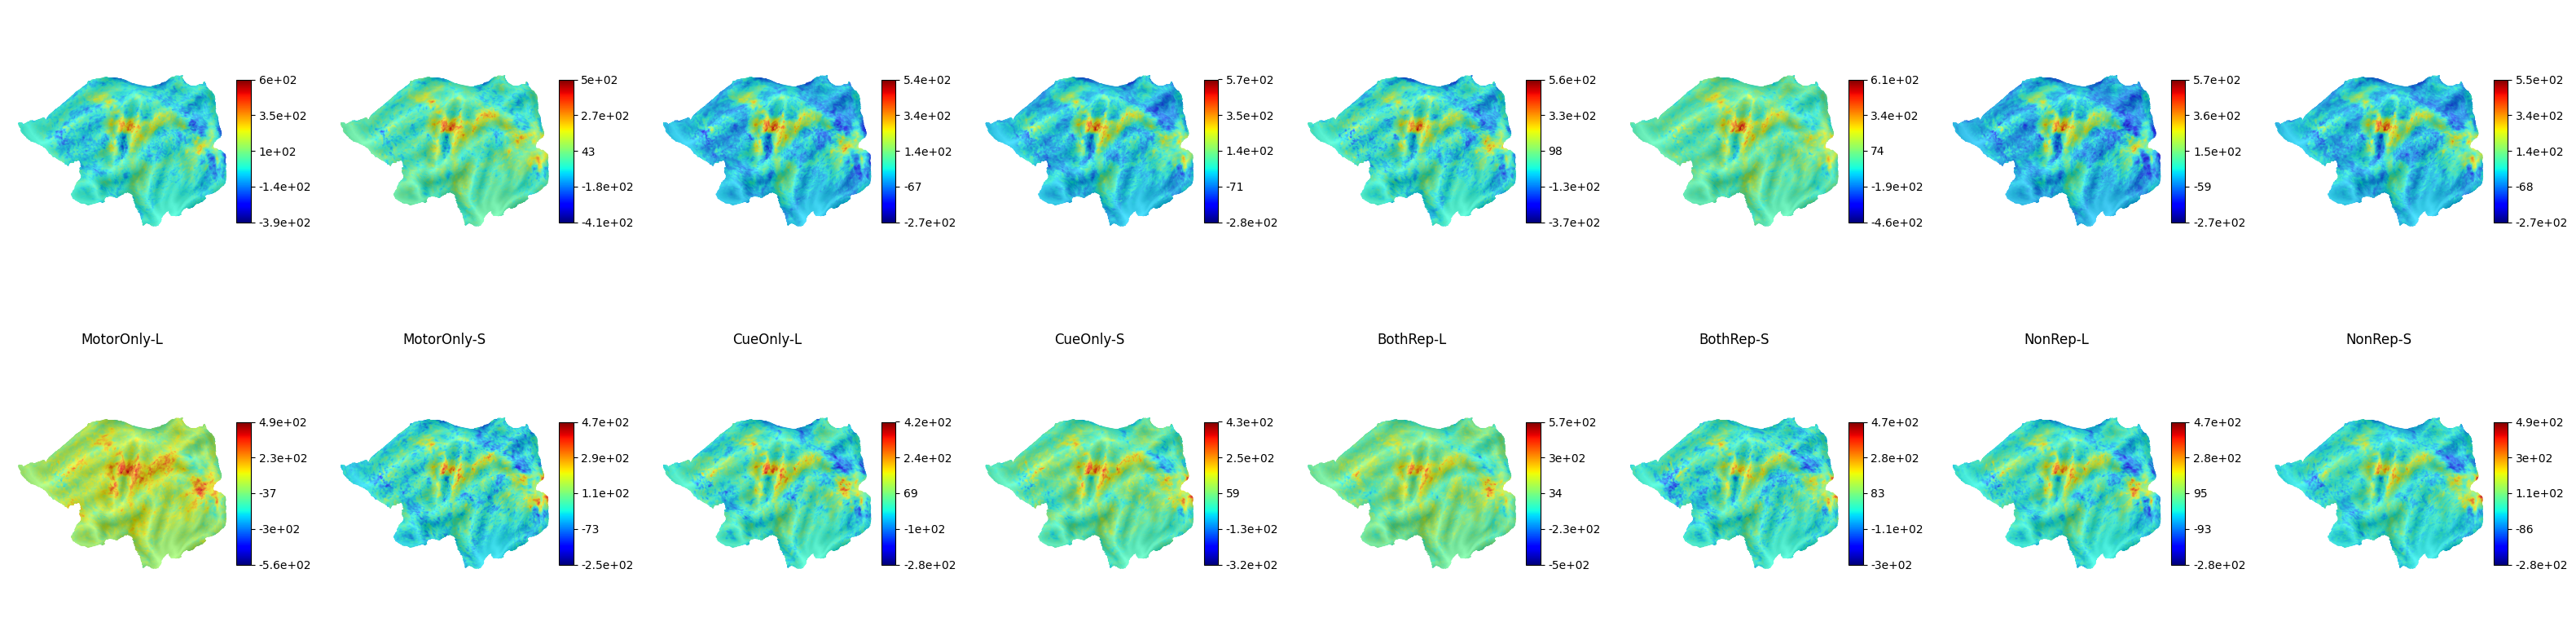

In [72]:
nrows=2
ncols=8
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols,5*nrows))

for ii, gg in enumerate(['S', 'R']):
    for jj, reg in enumerate(list_reg[:8]):
        ax = axs[ii,jj]
        plt.sca(ax)
        surf.plot.plotmap(
            data=betas[ii,:,jj].mean(axis=0),
            surf='fs32k_L', underlay=underlay, alpha=0.7,
            cmap=cm.jet, colorbar=True, #cscale=[-2,2]
            # overlay_type='label', label_names=['SMA','PMv','PMd','M1','S1','aSPL','pSPL','DSVC']
        )
        if ii==1:
            ax.set_title(reg)
        if jj==0:
            ax.set_ylabel(gg)

In [37]:
# fig.savefig(
#     join(dir_result,'fig.glm2.beta.surface.png'),
#     dpi=300, facecolor=[1,1,1,1],
#     bbox_inches='tight'
# )

---

## Contrast

$$RDM = \begin{bmatrix}
\textcolor{gray}{B} & C & C & C & S & N & N & N \\
C & \textcolor{gray}{B} & C & C & N & S & N & N \\
C & C & \textcolor{gray}{B} & C & N & N & S & N \\
C & C & C & \textcolor{gray}{B} & N & N & N & S \\
S & N & N & N & \textcolor{gray}{B} & C & C & C \\
N & S & N & N & C & \textcolor{gray}{B} & C & C \\
N & N & S & N & C & C & \textcolor{gray}{B} & C \\
N & N & N & S & C & C & C & \textcolor{gray}{B}
\end{bmatrix}$$
The number of elements on the upper triangle $= \frac{8\cdot 7}{2} = 28$
1. B: both of cue and sequence repetition (8 trials)
2. S: only sequence repetition (8 trials)
3. C: only cue repetition (24 trials)
4. N: no repetition (24 trials)

- Conditions:
    1. MotorOnly-L (S)
    2. MotorOnly-S (S)
    3. CueOnly-L (C)
    4. CueOnly-S (C)
    5. BothRep-L (B)
    6. BothRep-S (B)
    7. NonRep-L (N)
    8. NonRep-S (N)
    9. Non-Interest

- Contrasts:
    1. BothRep-L:  $c=[0\ 0\ 0\ 0\ 1\ 0\ 0\ 0\ 0]$
    2. CueRep-L:   $c=[0\ 0\ 1\ 0\ 0\ 0\ 0\ 0\ 0]$
    3. MotorRep-L: $c=[1\ 0\ 0\ 0\ 0\ 0\ 0\ 0\ 0]$
    4. NRep-L:     $c=[0\ 0\ 0\ 0\ 0\ 0\ 1\ 0\ 0]$
    5. BothRep-S:  $c=[0\ 0\ 0\ 0\ 0\ 1\ 0\ 0\ 0]$
    6. CueRep-S:   $c=[0\ 0\ 0\ 1\ 0\ 0\ 0\ 0\ 0]$
    7. MotorRep-S: $c=[0\ 1\ 0\ 0\ 0\ 0\ 0\ 0\ 0]$
    8. NRep-S:     $c=[0\ 0\ 0\ 0\ 0\ 0\ 0\ 1\ 0]$
    9. wRS-L:      $c=[0\ 0\ \!-\!1\ 0\ 1\ 0\ 0\ 0\ 0]$
    10. wRS-S:     $c=[0\ 0\ 0\ \!-\!1\ 0\ 1\ 0\ 0\ 0]$
    11. wRS-L-S:   $c=[0\ 0\ \!-\!1\ \!-\!1\ 1\ 1\ 0\ 0\ 0]$
    12. acRS-L:    $c=[1\ 0\ 0\ 0\ 0\ 0\ \!-\!1\ 0\ 0]$
    13. acRS-S:    $c=[0\ 1\ 0\ 0\ 0\ 0\ 0\ \!-\!1\ 0]$
    14. acRS-L-S:  $c=[1\ 1\ 0\ 0\ 0\ 0\ \!-\!1\ \!-\!1\ 0]$
    15. Letter:    $c=[1\ 0\ 1\ 0\ 1\ 0\ 1\ 0\ 0]*0.25$
    16. Spatial:   $c=[0\ 1\ 0\ 1\ 0\ 1\ 0\ 1\ 0]*0.25$
    17. L-S:       $c=[1\ \!-\!1\ 1\ \!-\!1\ 1\ \!-\!1\ 1\ \!-\!1\ 0]$

- Calculation:
    $$ \vec{c}\cdot\vec{\beta}=d $$

In [73]:
list_contrast = [
    'BothRep-L', 'CueRep-L', 'MotorRep-L', 'NRep-L', 'BothRep-S',
    'CueRep-S', 'MotorRep-S', 'NRep-S', 'wRS-L', 'wRS-S',
    'wRS-L-S', 'acRS-L', 'acRS-S', 'acRS-L-S', 'Letter',
    'Spatial', 'Letter-Spatial'
]
vec_contrast = {
    'BothRep-L':[0,0,0,0,1,0,0,0,0],
    'CueRep-L':[0,0,1,0,0,0,0,0,0],
    'MotorRep-L':[1,0,0,0,0,0,0,0,0],
    'NRep-L':[0,0,0,0,0,0,1,0,0],
    'BothRep-S':[0,0,0,0,0,1,0,0,0],
    'CueRep-S':[0,0,0,1,0,0,0,0,0],
    'MotorRep-S':[0,1,0,0,0,0,0,0,0],
    'NRep-S':[0,0,0,0,0,0,0,1,0],
    'wRS-L':[0,0,-1,0,1,0,0,0,0],
    'wRS-S':[0,0,0,-1,0,1,0,0,0],
    'wRS-L-S':[0,0,-1,-1,1,1,0,0,0],
    'acRS-L':[1,0,0,0,0,0,-1,0,0],
    'acRS-S':[0,1,0,0,0,0,0,-1,0],
    'acRS-L-S':[1,1,0,0,0,0,-1,-1,0],
    'Letter':[1,0,1,0,1,0,1,0,0],
    'Spatial':[0,1,0,1,0,1,0,1,0],
    'Letter-Spatial':[1,-1,1,-1,1,-1,1,-1,0]
}
for cont in list_contrast:
    vec = np.array(vec_contrast[cont])
    ## 양수 성분들의 합으로 나눠줘야 PSC를 제대로 구할 수 있음.
    sum_contrast = vec[vec>1e-10].sum()
    if abs(sum_contrast) > 0:
        vec = vec/sum_contrast
    print(len(vec), vec, sum_contrast)
    vec_contrast[cont] = vec

9 [0. 0. 0. 0. 1. 0. 0. 0. 0.] 1
9 [0. 0. 1. 0. 0. 0. 0. 0. 0.] 1
9 [1. 0. 0. 0. 0. 0. 0. 0. 0.] 1
9 [0. 0. 0. 0. 0. 0. 1. 0. 0.] 1
9 [0. 0. 0. 0. 0. 1. 0. 0. 0.] 1
9 [0. 0. 0. 1. 0. 0. 0. 0. 0.] 1
9 [0. 1. 0. 0. 0. 0. 0. 0. 0.] 1
9 [0. 0. 0. 0. 0. 0. 0. 1. 0.] 1
9 [ 0.  0. -1.  0.  1.  0.  0.  0.  0.] 1
9 [ 0.  0.  0. -1.  0.  1.  0.  0.  0.] 1
9 [ 0.   0.  -0.5 -0.5  0.5  0.5  0.   0.   0. ] 2
9 [ 1.  0.  0.  0.  0.  0. -1.  0.  0.] 1
9 [ 0.  1.  0.  0.  0.  0.  0. -1.  0.] 1
9 [ 0.5  0.5  0.   0.   0.   0.  -0.5 -0.5  0. ] 2
9 [0.25 0.   0.25 0.   0.25 0.   0.25 0.   0.  ] 4
9 [0.   0.25 0.   0.25 0.   0.25 0.   0.25 0.  ] 4
9 [ 0.25 -0.25  0.25 -0.25  0.25 -0.25  0.25 -0.25  0.  ] 4


In [74]:
beta = betas[0,0,:,:]
contrast = ''
beta_c = vec_contrast

<Axes: >

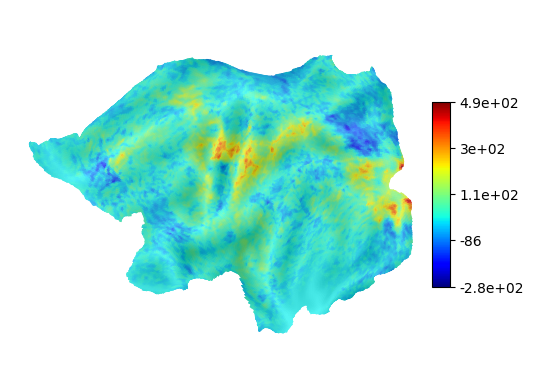

In [75]:
surf.plot.plotmap(
    data=betas[ii,:,jj].mean(axis=0),
    surf='fs32k_L', underlay=underlay, alpha=0.7,
    cmap=cm.jet, colorbar=True, #cscale=[-2,2]
    # overlay_type='label', label_names=['SMA','PMv','PMd','M1','S1','aSPL','pSPL','DSVC']
)

---

## Percent Signal Change

In [27]:
subj = 'S01'
fname = join(dir_glm,subj,'SPM.mat')
feature = h5py.File(fname)
# feature = scipy.io.loadmat(fname)
print(feature.keys())

data = feature['SPM']
# data.keys()

<KeysViewHDF5 ['#refs#', 'SPM']>


In [28]:
print(data['xX'].keys())
mat_X = data['xX']['X'][:].T
print(mat_X.shape)

## interest
idx_iC = np.concatenate(data['xX']['iC'][:]).astype(int) - 1
print(idx_iC)
## non-insterest (baseline)
idx_iB = np.concatenate(data['xX']['iB'][:]).astype(int) - 1
print(idx_iB)

# mat_X = mat_X[:,idx_col]
# print(mat_X.shape)

<KeysViewHDF5 ['Bcov', 'K', 'V', 'W', 'X', 'erdf', 'iB', 'iC', 'iG', 'iH', 'nKX', 'name', 'pKX', 'trRV', 'trRVRV', 'xKXs']>
(3280, 80)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71]
[72 73 74 75 76 77 78 79]


In [38]:
betas.shape

(2, 12, 8, 32492)

In [31]:
h = np.median(
    np.max(mat_X[:,idx_iC], axis=0)
)
numB = len(idx_iB)

8

---